# Sentiment Analysis Using TinyBERT

# Why Transformers

*   Accurate
*   Can be used for wide variety of task
*   Easy to use
*   It is game changer in NLP




In [3]:
# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')



In [4]:
import pandas as pd
from datasets import Dataset

data = pd.read_csv('/Users/preetyrai/mlops-boto3/sentimentclassification/IMDB-Dataset.csv')
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
dataset = Dataset.from_pandas(data)
dataset = dataset.train_test_split(test_size=0.3)
dataset


DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 15000
    })
})

In [6]:
data['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
label2id = {'negative': 0, 'positive': 1}
id2label = {0:'negative', 1:'positive'}

dataset = dataset.map(lambda x: {'label': label2id[x['sentiment']]})


python(18508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [8]:
dataset['train'][0]


{'review': "Sean, you know I think that you are absolutely the greatest actor in the world, but I can't commend you for this. Comedy just isn't your strong suit.<br /><br />However, it wasn't all your fault. Some of the stuff was just too hard to understand. Alfred Lynch did a decent job, but you gotta wonder where the lines came from from the beginning.<br /><br />Once again, Sean... I apologize.",
 'sentiment': 'negative',
 'label': 0}

# Data Tokenization

In [9]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [10]:
tokenizer(dataset['train'][0]['review'])

def tokenize(batch):
    temp = tokenizer(batch['review'], padding=True, truncation=True, max_length=300)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [22]:
dataset['train'][0].keys()


dict_keys(['review', 'sentiment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

# Building Model Evaluation Functions

### Building Model Evaluation Functions
https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [24]:
!pip install evaluate

python(33563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


In [25]:

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



# Model Building

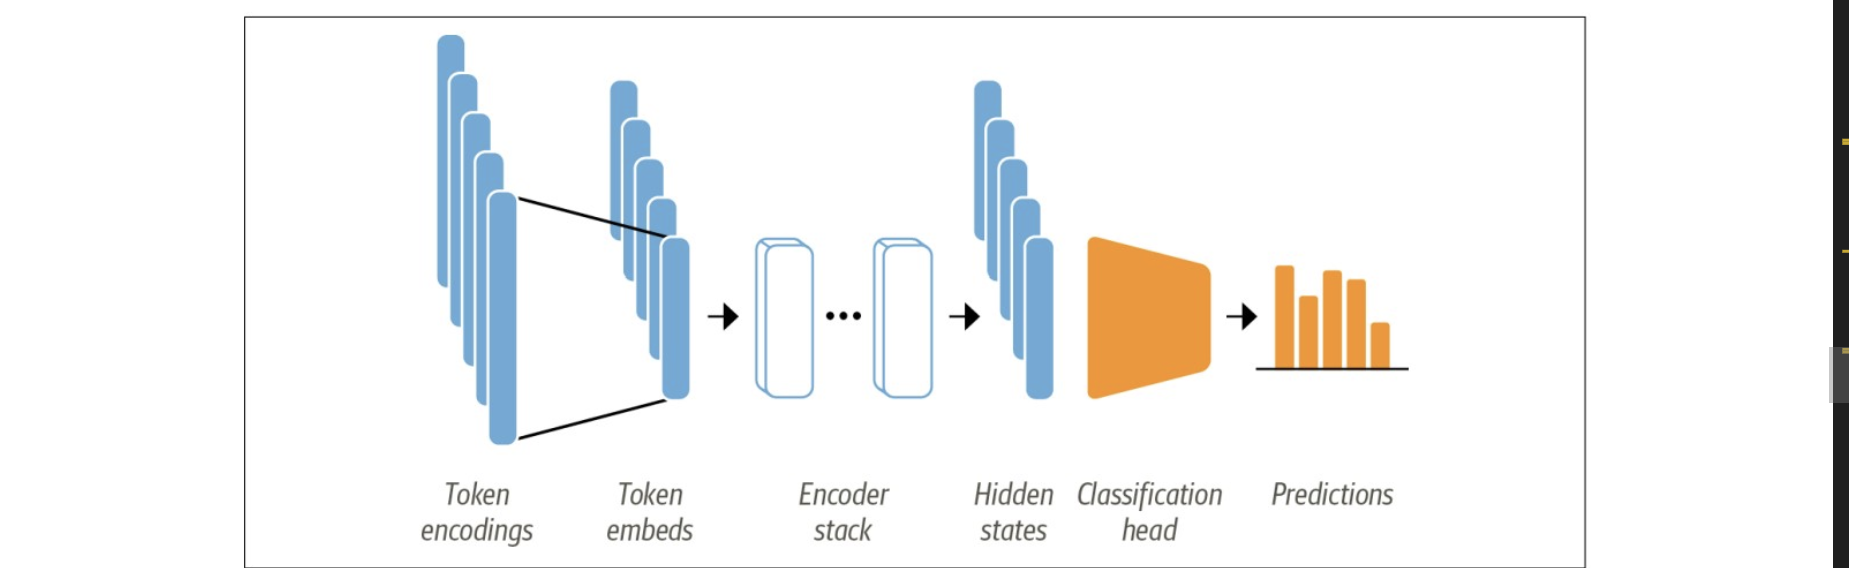

In [13]:
from IPython.display import display, Image

display(Image(filename='/Users/preetyrai/mlops-boto3/sentimentclassification/image.png'))

- AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs
- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel.
- The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.


In [20]:
!pip install tf-keras


python(30195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00a 0:00:01


In [21]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)



pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [29]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


In [ ]:
trainer.train()


In [ ]:
trainer.evaluate()


# Model Save and Load for Inference

In [ ]:
trainer.save_model('tinybert-sentiment-analysis')


In [ ]:
data = ['this movie was horrible, the plot was really boring. acting was okay',
        'the movie is really sucked. there is not plot and acting was bad',
        'what a beautiful movie. great plot. acting was good. will see it again']



In [ ]:
from transformers import pipeline
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model='tinybert-sentiment-analysis', device=device)

classifier(data)



# Push Model to AWS S3

In [ ]:
import boto3

s3 = boto3.client('s3')

bucket_name = 'mlopssentimentanalysis-8989'

def create_bucket(bucket_name):
    response = s3.list_buckets()
    buckets = [buck['Name'] for buck in response['Buckets']]
    if bucket_name not in buckets:
        s3.create_bucket(Bucket=bucket_name)
        print("Bucket is created")

    else:
        print("Bucket already exists in your account!!! Feel free to use it.")

create_bucket(bucket_name)



BucketAlreadyExists: An error occurred (BucketAlreadyExists) when calling the CreateBucket operation: The requested bucket name is not available. The bucket namespace is shared by all users of the system. Please select a different name and try again.

In [ ]:
# upload model folder to s3 bucket ml-models/tinybert-sentiment-analysis
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlopssentimentanalysis-8989'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('tinybert-sentiment-analysis', 'ml-models/tinybert-sentiment-analysis')




In [ ]:
# s3://mlops-kgptalkie/ml-models/tinybert-sentiment-analysis/

